In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import ast
from collections import Counter

# Set style for thesis-ready plots
plt.style.use('seaborn-v0_8-paper')
sns.set_palette('colorblind')
plt.rcParams['figure.dpi'] = 300
plt.rcParams['savefig.dpi'] = 300
plt.rcParams['font.size'] = 10
plt.rcParams['axes.labelsize'] = 11
plt.rcParams['axes.titlesize'] = 12
plt.rcParams['legend.fontsize'] = 10

print("✓ Libraries imported")

✓ Libraries imported


## 1. Load Data and Compute Mitigation Effectiveness

## Important: Understanding Vulnerability Counts

### Two Perspectives on Counting:

**Total Counts** (may include duplicates when same CWE detected by multiple tools):
- `total_vulnerabilities_identified`: All occurrences
- `total_vulnerabilities_fixed`: All fixed occurrences
- `total_vulnerabilities_remaining`: All remaining occurrences

**Unique CWE Counts** (each CWE type counted once):
- `unique_cwes_identified`: Distinct CWE types found
- `unique_cwes_fixed`: Distinct CWE types successfully fixed
- `unique_cwes_remaining`: Distinct CWE types not fixed

### For Mitigation & Fix Provider Analysis:
- **Fix success rates**: Can use either, but be consistent
- **Fix provider counts**: Aligned with **unique CWEs** (NOT total counts)
  - `fix_provider_llm` + `fix_provider_rule_based` + `fix_provider_unknown` = `unique_cwes_fixed`
- **Comparing fix methods**: Use unique counts for accuracy

This ensures fix provider analysis correctly reflects distinct vulnerability types fixed, not duplicate detections.

In [2]:
# Load evaluation data
data_path = Path('data/evaluation_base.csv')

if not data_path.exists():
    print(f"❌ ERROR: {data_path} not found!")
    raise FileNotFoundError(f"Required file not found: {data_path}")

df = pd.read_csv(data_path)

print(f"✓ Loaded {len(df)} workflows")
print(f"\nColumns: {list(df.columns)[:10]}...")  # Show first 10 columns
print(f"\nPrompt type distribution:")
print(df['prompt_type'].value_counts())

✓ Loaded 84 workflows

Columns: ['workflow_id', 'workflow', 'timestamp', 'file', 'source_file', 'prompt_type', 'prompt', 'llm_response', 'vulnerabilities_found', 'total_vulnerabilities_identified']...

Prompt type distribution:
prompt_type
SecurityEval    42
Manual          42
Name: count, dtype: int64


In [3]:
# Helper function to safely parse CWE lists
def safe_parse_cwes(cwe_str):
    """Parse CWE string/list safely, return list of CWE numbers."""
    if pd.isna(cwe_str) or cwe_str == '' or cwe_str == '[]':
        return []
    
    try:
        # Try to evaluate as Python literal
        if isinstance(cwe_str, str):
            parsed = ast.literal_eval(cwe_str)
            if isinstance(parsed, list):
                return [str(c).strip() for c in parsed if c]
            return [str(parsed).strip()]
        elif isinstance(cwe_str, list):
            return [str(c).strip() for c in cwe_str if c]
        else:
            return [str(cwe_str).strip()]
    except:
        # If parsing fails, try splitting by comma
        if isinstance(cwe_str, str):
            parts = cwe_str.strip('[]').split(',')
            return [p.strip().strip("'\"") for p in parts if p.strip()]
        return []

print("✓ Helper functions defined")

✓ Helper functions defined


In [4]:
# Compute mitigation metrics per workflow
mitigation_data = []

for idx, row in df.iterrows():
    # Parse CWE lists
    initial_bandit_cwes = safe_parse_cwes(row.get('initial_detection_bandit_cwes', []))
    initial_semgrep_cwes = safe_parse_cwes(row.get('initial_detection_semgrep_cwes', []))
    initial_ast_cwes = safe_parse_cwes(row.get('initial_detection_ast_cwes', []))
    
    iteration_bandit_cwes = safe_parse_cwes(row.get('iteration_detection_bandit_cwes', []))
    iteration_semgrep_cwes = safe_parse_cwes(row.get('iteration_detection_semgrep_cwes', []))
    iteration_ast_cwes = safe_parse_cwes(row.get('iteration_detection_ast_cwes', []))
    
    fixed_cwes = safe_parse_cwes(row.get('fixed_cwes', []))
    remaining_cwes = safe_parse_cwes(row.get('remaining_cwes', []))
    
    # Compute total detected CWEs (unique across all tools and iterations)
    all_detected_cwes = set(initial_bandit_cwes + initial_semgrep_cwes + initial_ast_cwes +
                            iteration_bandit_cwes + iteration_semgrep_cwes + iteration_ast_cwes)
    
    # Initial detection counts
    initial_total = row.get('initial_detection_bandit_count', 0) + \
                   row.get('initial_detection_semgrep_count', 0) + \
                   row.get('initial_detection_ast_count', 0)
    
    # Iteration detection counts
    iteration_total = row.get('iteration_detection_bandit_count', 0) + \
                     row.get('iteration_detection_semgrep_count', 0) + \
                     row.get('iteration_detection_ast_count', 0)
    
    # Counts from vulnerability tracking
    total_identified = row.get('total_vulnerabilities_identified', len(all_detected_cwes))
    total_fixed = row.get('total_vulnerabilities_fixed', len(fixed_cwes))
    total_remaining = row.get('total_vulnerabilities_remaining', len(remaining_cwes))
    
    # Fix success rate
    if total_identified > 0:
        fix_success_rate = (total_fixed / total_identified) * 100
    else:
        fix_success_rate = 0.0
    
    mitigation_data.append({
        'workflow_id': row.get('workflow_id', idx),
        'file': row.get('file', 'unknown'),
        'prompt_type': row.get('prompt_type', 'unknown'),
        'initial_detections': initial_total,
        'iteration_detections': iteration_total,
        'total_detected_cwes': len(all_detected_cwes),
        'total_identified': total_identified,
        'total_fixed': total_fixed,
        'total_remaining': total_remaining,
        'fix_success_rate': fix_success_rate,
        'iterations_count': row.get('iterations_count', 0),
        'fixed_cwes_list': fixed_cwes,
        'remaining_cwes_list': remaining_cwes
    })

mitigation_df = pd.DataFrame(mitigation_data)

print("\n" + "="*70)
print("MITIGATION SUMMARY STATISTICS")
print("="*70)
print(f"Total workflows: {len(mitigation_df)}")
print(f"\nTotal vulnerability occurrences (may include duplicates):")
print(f"  Identified: {mitigation_df['total_identified'].sum()}")
print(f"  Fixed: {mitigation_df['total_fixed'].sum()}")
print(f"  Remaining: {mitigation_df['total_remaining'].sum()}")

# Check if unique CWE columns exist
if 'unique_cwes_fixed' in df.columns and 'unique_cwes_identified' in df.columns:
    print(f"\nUnique CWE types (no duplicates):")
    print(f"  Identified: {df['unique_cwes_identified'].sum()}")
    print(f"  Fixed: {df['unique_cwes_fixed'].sum()}")
    print(f"  Remaining: {df['unique_cwes_remaining'].sum()}")
    unique_fix_rate = (df['unique_cwes_fixed'].sum() / df['unique_cwes_identified'].sum() * 100)
    print(f"  Fix success rate (unique CWEs): {unique_fix_rate:.2f}%")

print(f"\nOverall fix success rate (total occurrences): {(mitigation_df['total_fixed'].sum() / mitigation_df['total_identified'].sum() * 100):.2f}%")
print("="*70)


MITIGATION SUMMARY STATISTICS
Total workflows: 84

Total vulnerability occurrences (may include duplicates):
  Identified: 215
  Fixed: 202
  Remaining: 13

Unique CWE types (no duplicates):
  Identified: 59
  Fixed: 48
  Remaining: 11
  Fix success rate (unique CWEs): 81.36%

Overall fix success rate (total occurrences): 93.95%


In [5]:
# Display sample of mitigation data
display_cols = ['workflow_id', 'file', 'prompt_type', 'total_identified', 
                'total_fixed', 'total_remaining', 'fix_success_rate']
print("\nSample Mitigation Data:")
display(mitigation_df[display_cols].head(10))


Sample Mitigation Data:


,workflow_id,file,prompt_type,total_identified,total_fixed,total_remaining,fix_success_rate
0,20251219_151500,CWE-020/author_1.py,SecurityEval,2,2,0,100.0
1,20251219_152650,CWE-020/author_2.py,SecurityEval,0,0,0,0.0
2,20251219_154533,CWE-022/author_1.py,SecurityEval,3,3,0,100.0
3,20251219_155128,CWE-022/author_2.py,SecurityEval,0,0,0,0.0
4,20251219_155343,CWE-078/author_1.py,SecurityEval,0,0,0,0.0
5,20251219_164453,CWE-080/author_1.py,SecurityEval,6,6,0,100.0
6,20251219_164921,CWE-089/author_1.py,SecurityEval,0,0,0,0.0
7,20251219_165024,CWE-094/author_1.py,SecurityEval,5,5,0,100.0
8,20251219_165140,CWE-095/author_1.py,SecurityEval,4,4,0,100.0
9,20251219_165330,CWE-116/author_1.py,SecurityEval,0,0,0,0.0


In [6]:
# Export mitigation summary
output_path = Path('data/mitigation_summary.csv')
export_df = mitigation_df.copy()
export_df['fixed_cwes_list'] = export_df['fixed_cwes_list'].apply(str)
export_df['remaining_cwes_list'] = export_df['remaining_cwes_list'].apply(str)
export_df.to_csv(output_path, index=False)
print(f"✓ Mitigation summary exported to: {output_path}")

✓ Mitigation summary exported to: data\mitigation_summary.csv


## 2. Visualization: Fixed vs Remaining Vulnerabilities

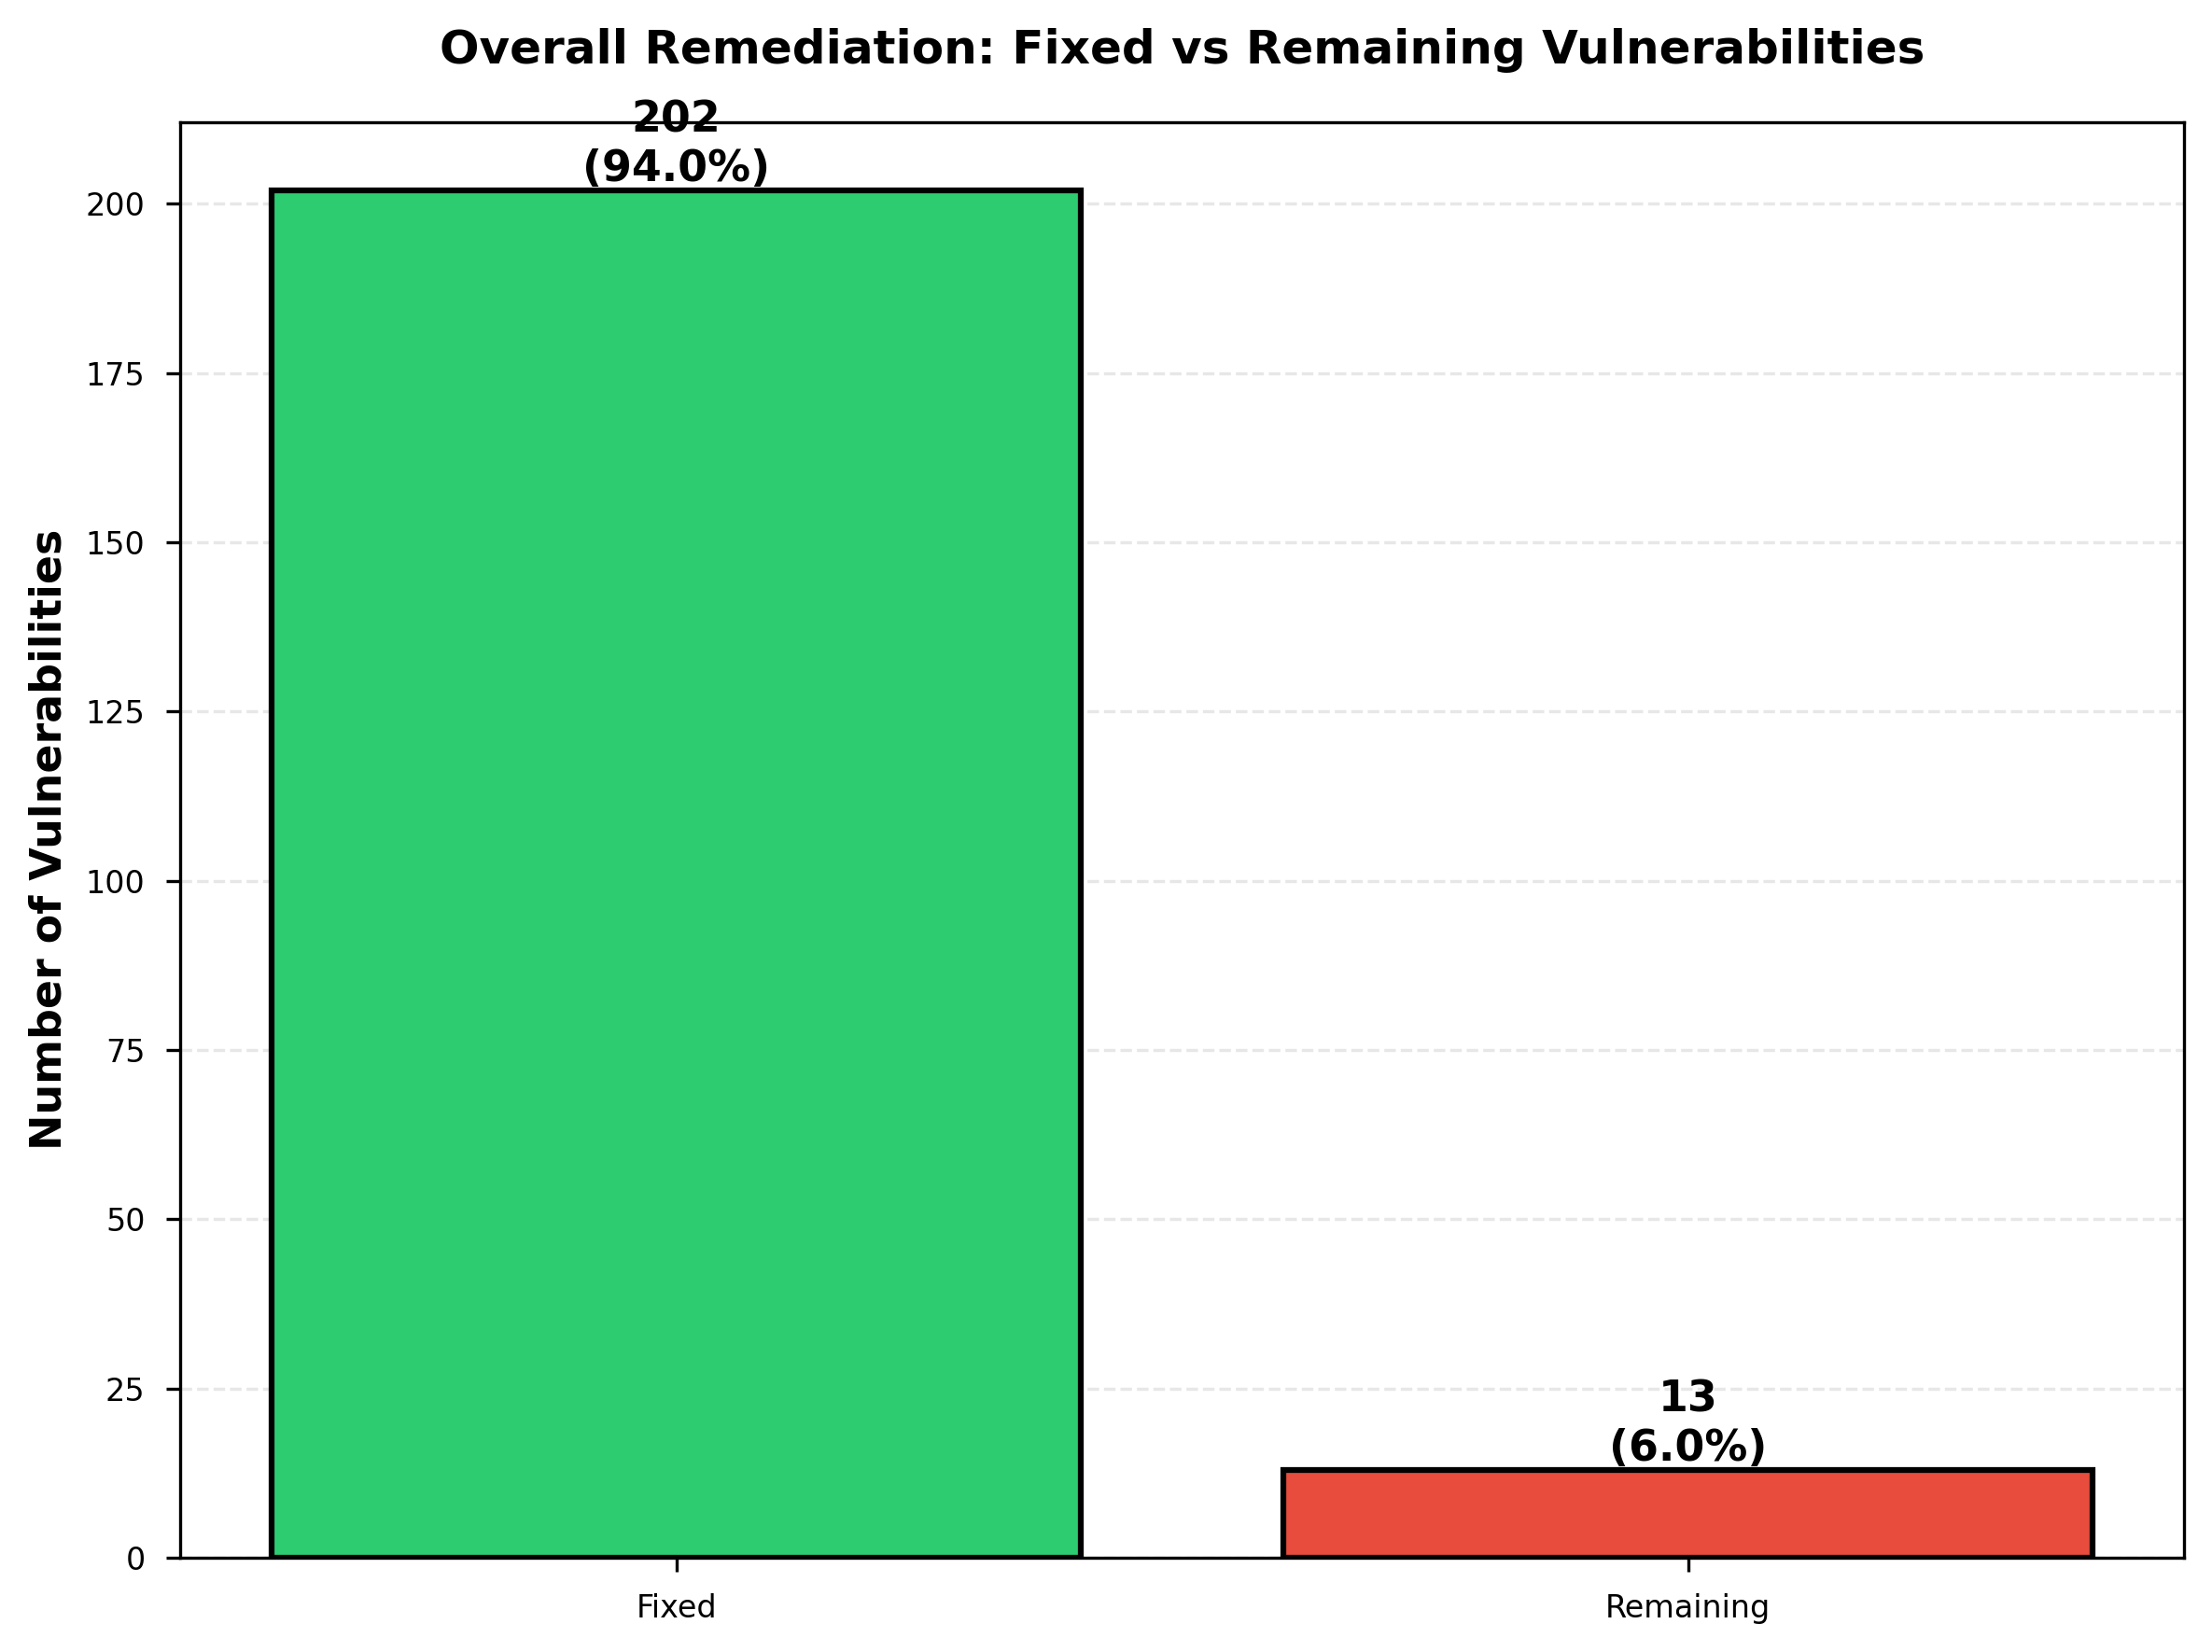

✓ Fixed vs remaining plot saved


In [7]:
# Plot 1: Overall Fixed vs Remaining Vulnerabilities
fig, ax = plt.subplots(figsize=(8, 6))

total_fixed = mitigation_df['total_fixed'].sum()
total_remaining = mitigation_df['total_remaining'].sum()

categories = ['Fixed', 'Remaining']
values = [total_fixed, total_remaining]
colors = ['#2ecc71', '#e74c3c']

bars = ax.bar(categories, values, color=colors, edgecolor='black', linewidth=1.5)

# Add value labels
for bar, val in zip(bars, values):
    height = bar.get_height()
    percentage = (val / sum(values)) * 100
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{int(val)}\n({percentage:.1f}%)',
            ha='center', va='bottom', fontsize=11, fontweight='bold')

ax.set_ylabel('Number of Vulnerabilities', fontsize=11, fontweight='bold')
ax.set_title('Overall Remediation: Fixed vs Remaining Vulnerabilities', 
             fontsize=12, fontweight='bold', pad=15)
ax.grid(axis='y', alpha=0.3, linestyle='--')
ax.set_axisbelow(True)

plt.tight_layout()
plt.savefig('data/mitigation_fixed_vs_remaining.png', bbox_inches='tight')
plt.show()

print("✓ Fixed vs remaining plot saved")

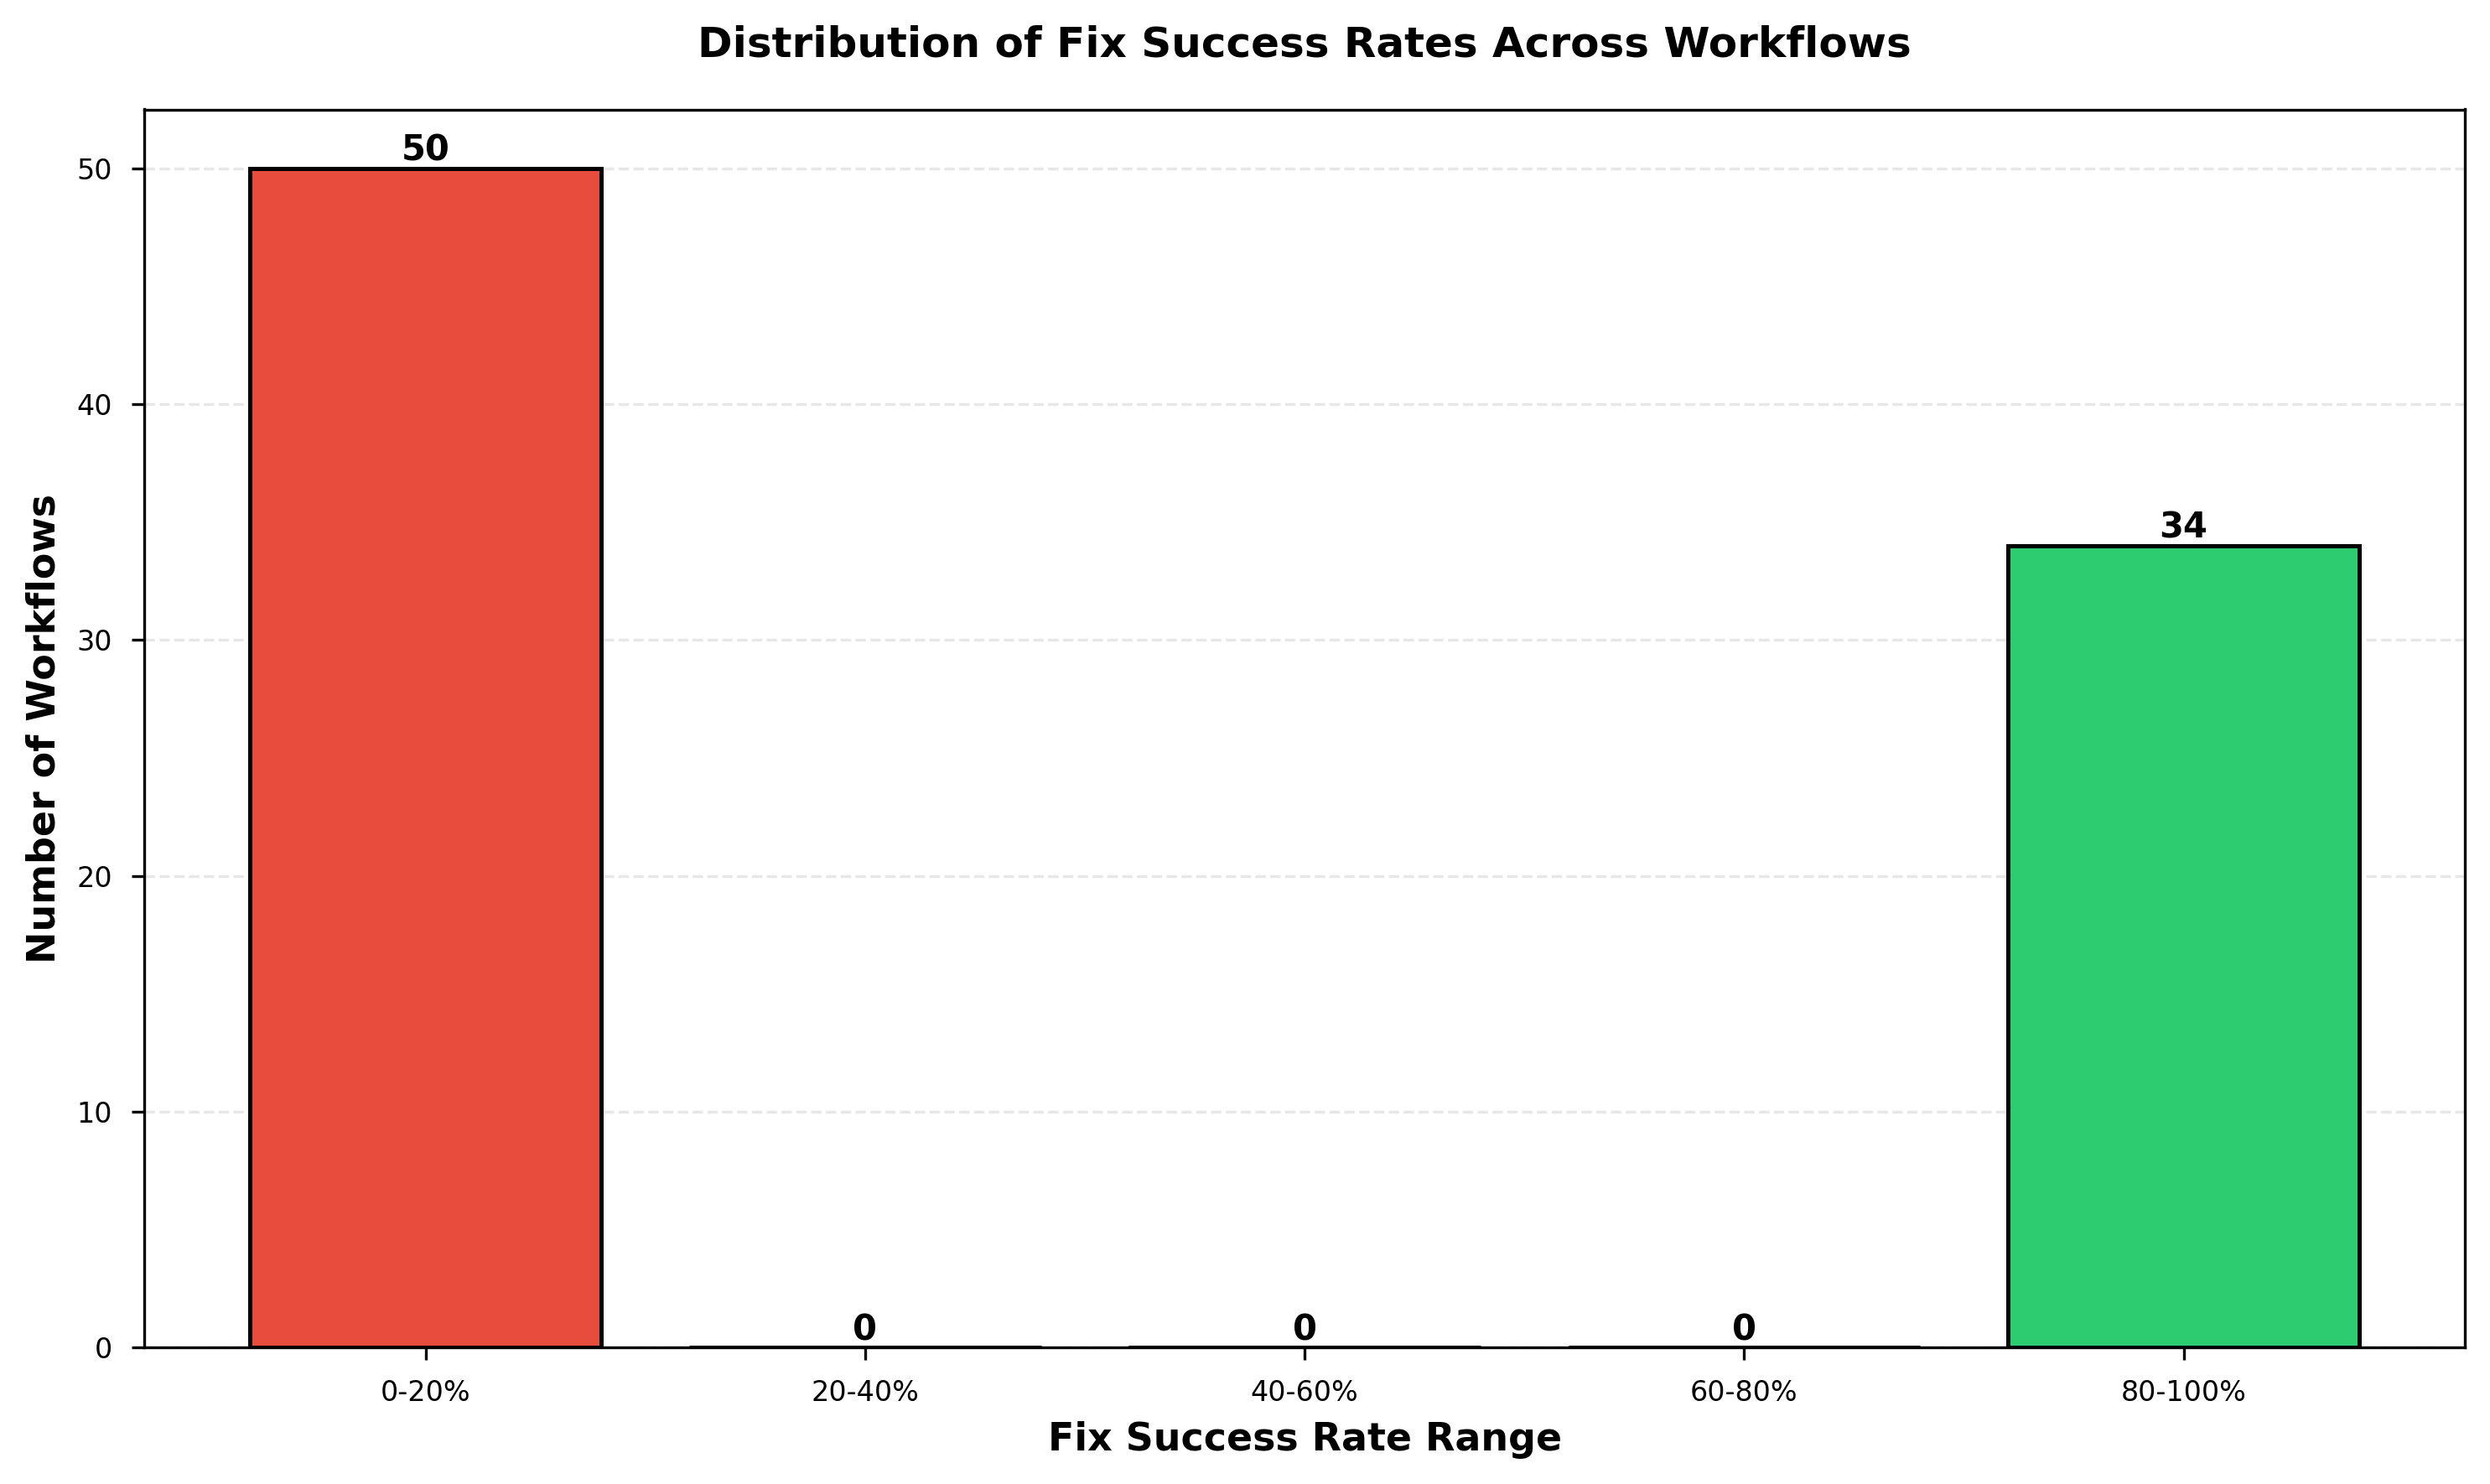

✓ Fix success rate distribution plot saved


In [8]:
# Plot 2: Fix Success Rate Distribution
fig, ax = plt.subplots(figsize=(10, 6))

# Create bins for success rates
bins = [0, 20, 40, 60, 80, 100]
labels = ['0-20%', '20-40%', '40-60%', '60-80%', '80-100%']

mitigation_df['success_rate_bin'] = pd.cut(mitigation_df['fix_success_rate'], 
                                            bins=bins, labels=labels, include_lowest=True)

bin_counts = mitigation_df['success_rate_bin'].value_counts().sort_index()

colors_gradient = ['#e74c3c', '#e67e22', '#f39c12', '#52d726', '#2ecc71']
bars = ax.bar(range(len(bin_counts)), bin_counts.values, 
              color=colors_gradient, edgecolor='black', linewidth=1.2)

# Add value labels
for i, (bar, val) in enumerate(zip(bars, bin_counts.values)):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{int(val)}',
            ha='center', va='bottom', fontsize=10, fontweight='bold')

ax.set_xticks(range(len(bin_counts)))
ax.set_xticklabels(bin_counts.index)
ax.set_xlabel('Fix Success Rate Range', fontsize=11, fontweight='bold')
ax.set_ylabel('Number of Workflows', fontsize=11, fontweight='bold')
ax.set_title('Distribution of Fix Success Rates Across Workflows', 
             fontsize=12, fontweight='bold', pad=15)
ax.grid(axis='y', alpha=0.3, linestyle='--')
ax.set_axisbelow(True)

plt.tight_layout()
plt.savefig('data/mitigation_success_rate_distribution.png', bbox_inches='tight')
plt.show()

print("✓ Fix success rate distribution plot saved")

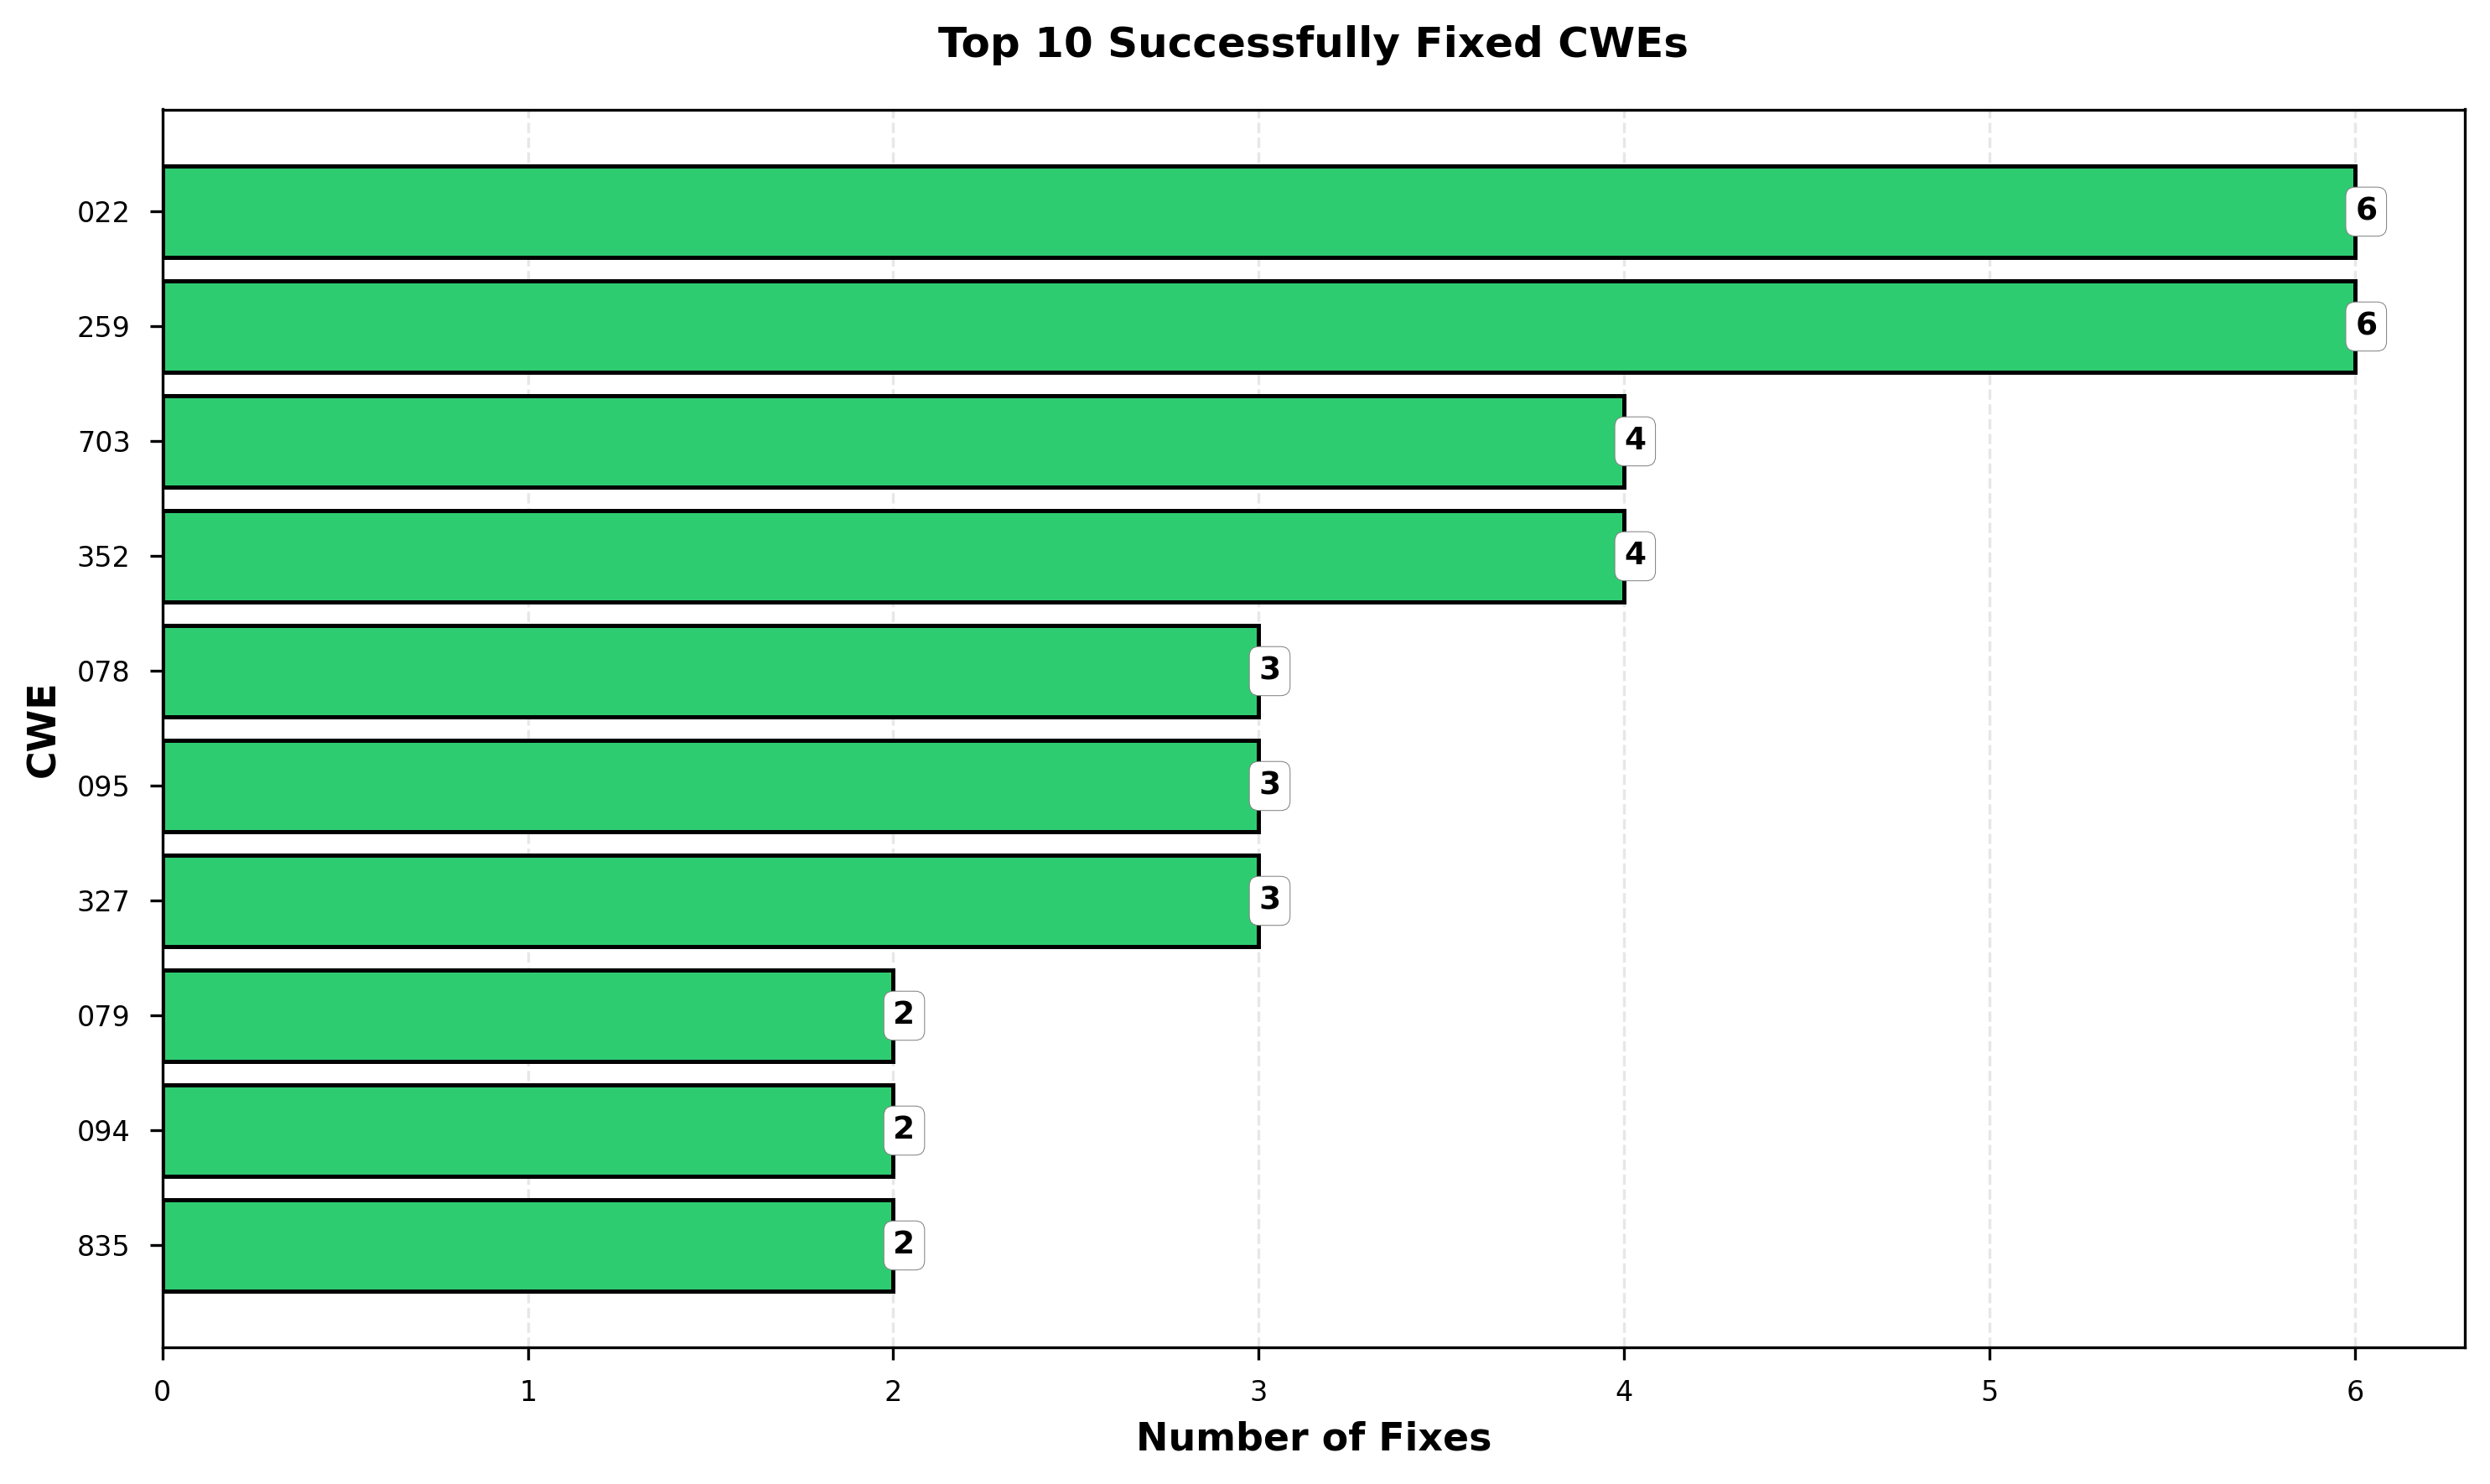

✓ Top fixed CWEs plot saved


In [9]:
# Plot 3: Top Fixed CWEs
all_fixed_cwes = []
for cwes in mitigation_df['fixed_cwes_list']:
    all_fixed_cwes.extend(cwes)

fixed_cwe_counts = Counter(all_fixed_cwes)
top_fixed = dict(fixed_cwe_counts.most_common(10))

if top_fixed:
    fig, ax = plt.subplots(figsize=(10, 6))
    
    cwes = list(top_fixed.keys())
    counts = list(top_fixed.values())
    
    bars = ax.barh(range(len(cwes)), counts, color='#2ecc71', 
                   edgecolor='black', linewidth=1.2)
    
    # Add value labels
    for bar, val in zip(bars, counts):
        width = bar.get_width()
        ax.text(width, bar.get_y() + bar.get_height()/2.,
                f'{int(val)}',
                ha='left', va='center', fontsize=9, fontweight='bold', 
                bbox=dict(boxstyle='round,pad=0.3', facecolor='white', edgecolor='gray'))
    
    ax.set_yticks(range(len(cwes)))
    ax.set_yticklabels(cwes)
    ax.set_xlabel('Number of Fixes', fontsize=11, fontweight='bold')
    ax.set_ylabel('CWE', fontsize=11, fontweight='bold')
    ax.set_title('Top 10 Successfully Fixed CWEs', fontsize=12, fontweight='bold', pad=15)
    ax.grid(axis='x', alpha=0.3, linestyle='--')
    ax.set_axisbelow(True)
    ax.invert_yaxis()
    
    plt.tight_layout()
    plt.savefig('data/mitigation_top_fixed_cwes.png', bbox_inches='tight')
    plt.show()
    
    print("✓ Top fixed CWEs plot saved")
else:
    print("No fixed CWEs found to plot")

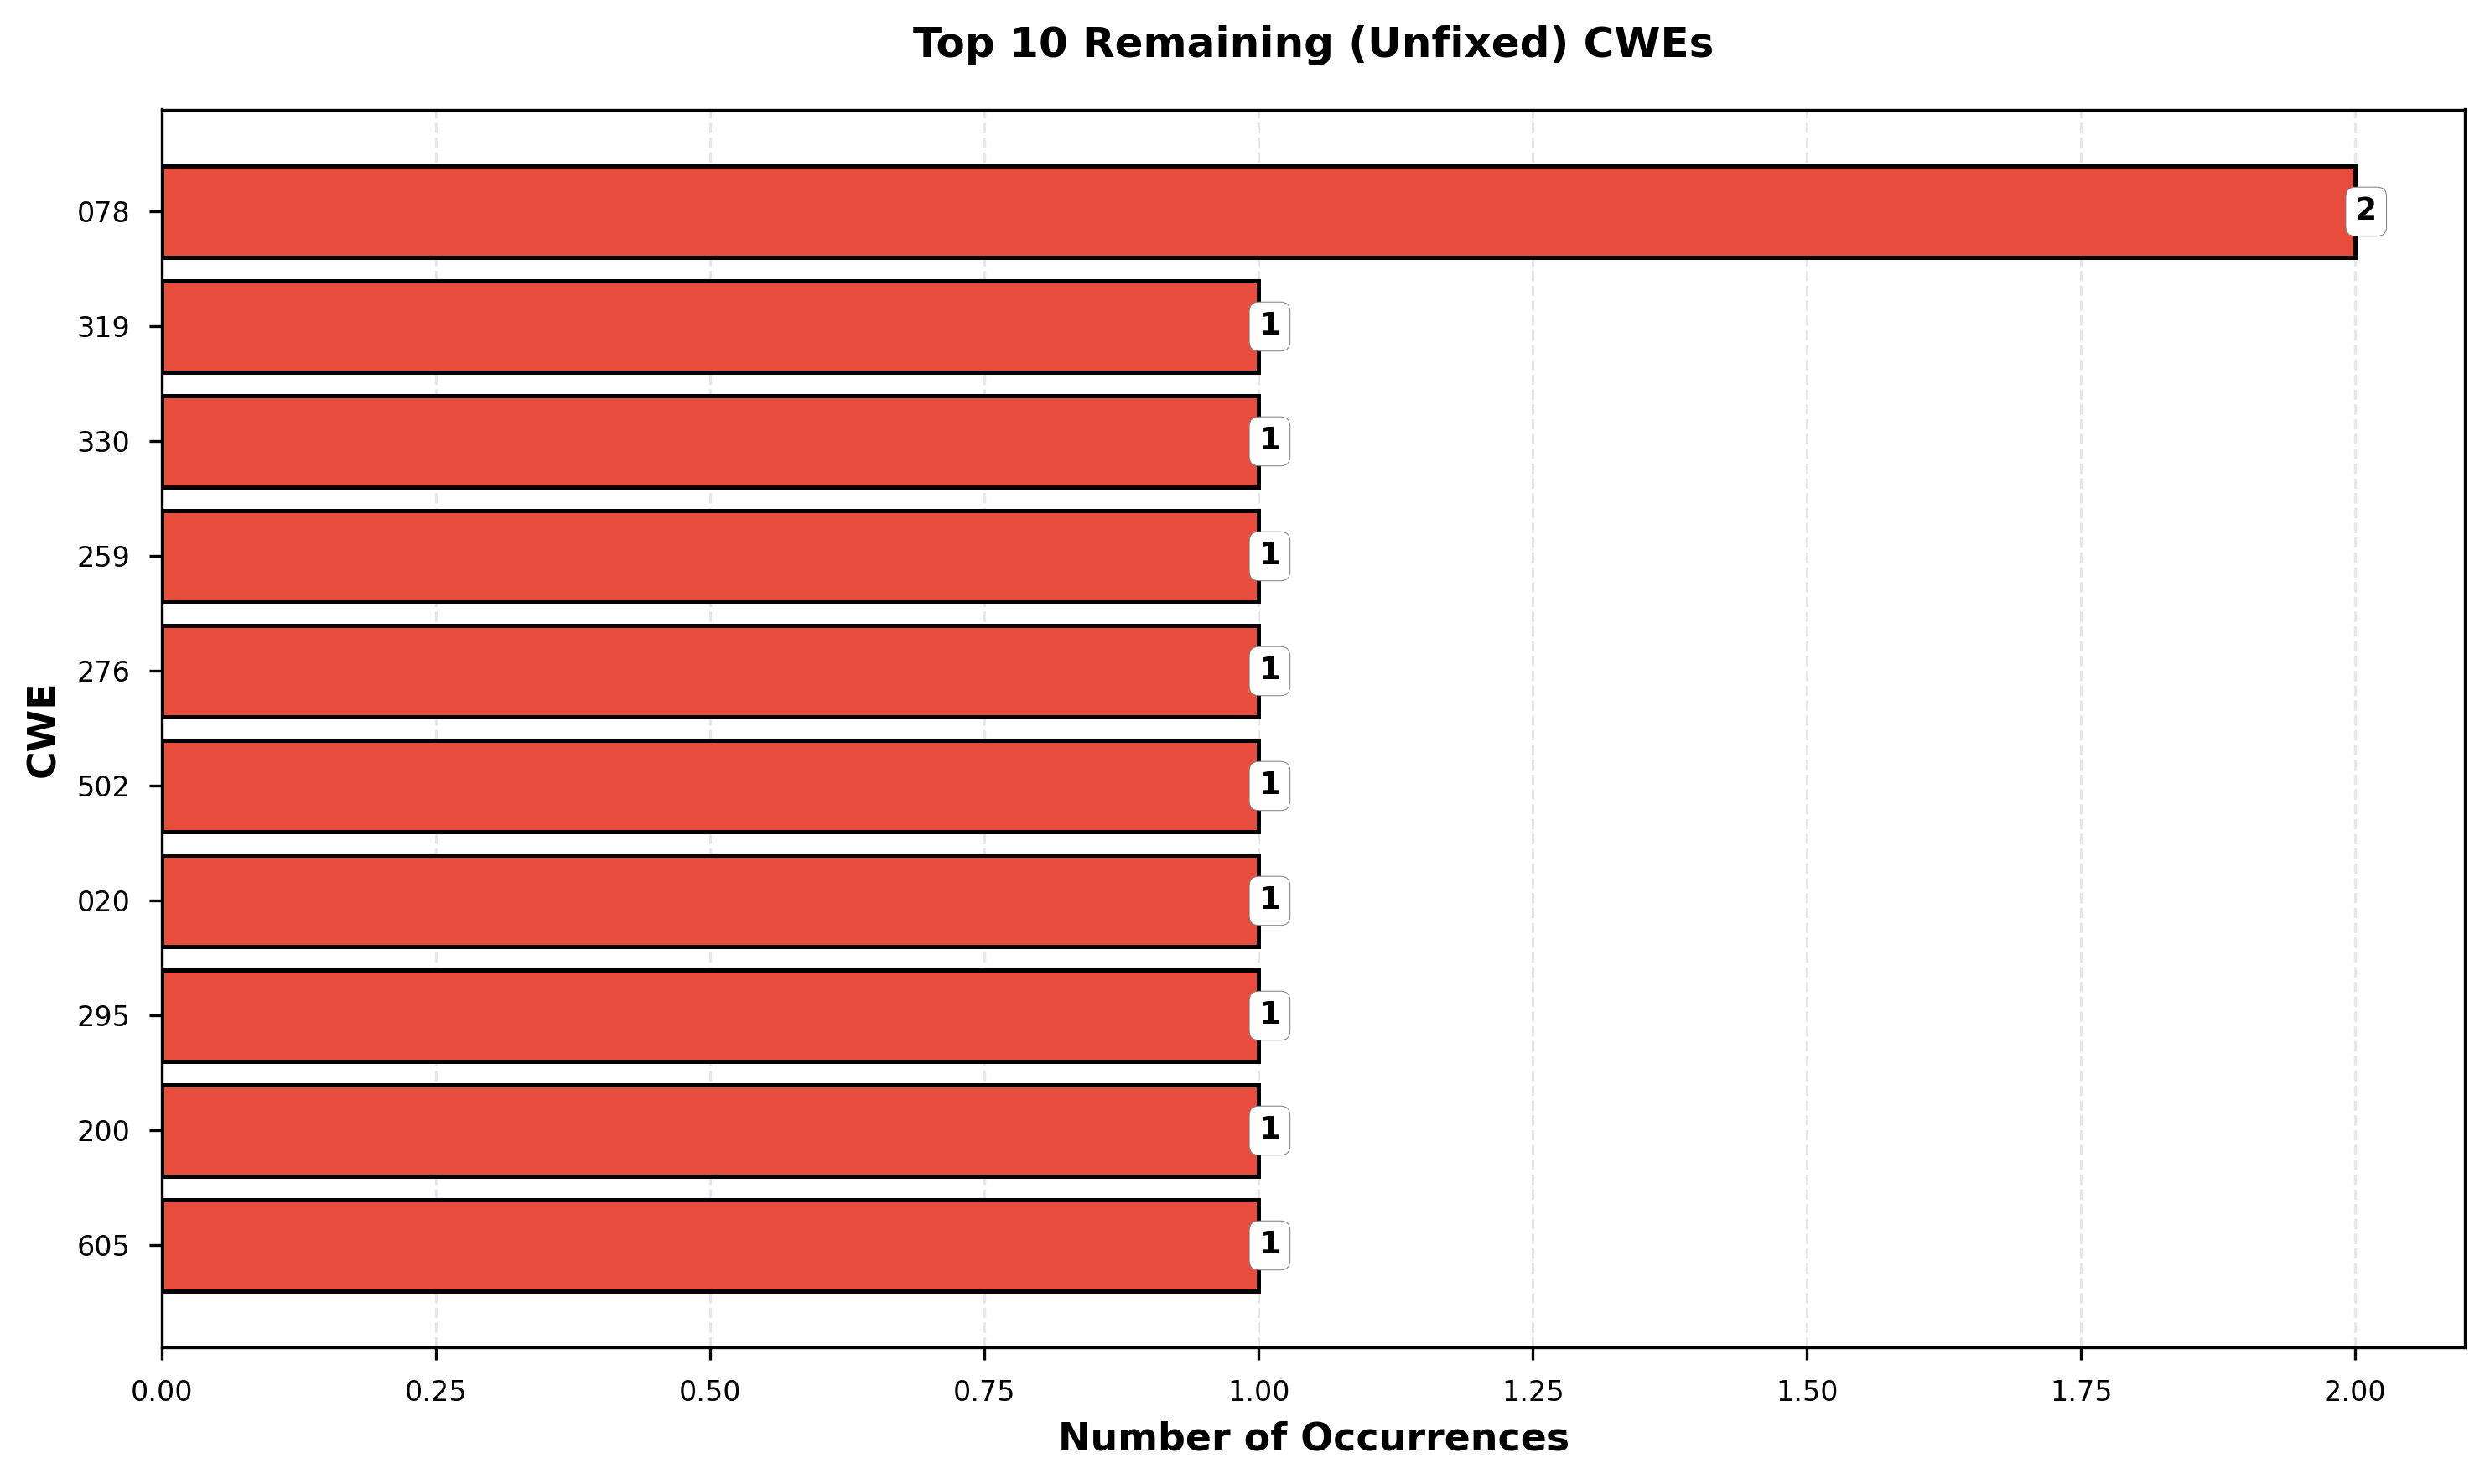

✓ Top remaining CWEs plot saved


In [10]:
# Plot 4: Top Remaining CWEs
all_remaining_cwes = []
for cwes in mitigation_df['remaining_cwes_list']:
    all_remaining_cwes.extend(cwes)

remaining_cwe_counts = Counter(all_remaining_cwes)
top_remaining = dict(remaining_cwe_counts.most_common(10))

if top_remaining:
    fig, ax = plt.subplots(figsize=(10, 6))
    
    cwes = list(top_remaining.keys())
    counts = list(top_remaining.values())
    
    bars = ax.barh(range(len(cwes)), counts, color='#e74c3c', 
                   edgecolor='black', linewidth=1.2)
    
    # Add value labels
    for bar, val in zip(bars, counts):
        width = bar.get_width()
        ax.text(width, bar.get_y() + bar.get_height()/2.,
                f'{int(val)}',
                ha='left', va='center', fontsize=9, fontweight='bold',
                bbox=dict(boxstyle='round,pad=0.3', facecolor='white', edgecolor='gray'))
    
    ax.set_yticks(range(len(cwes)))
    ax.set_yticklabels(cwes)
    ax.set_xlabel('Number of Occurrences', fontsize=11, fontweight='bold')
    ax.set_ylabel('CWE', fontsize=11, fontweight='bold')
    ax.set_title('Top 10 Remaining (Unfixed) CWEs', fontsize=12, fontweight='bold', pad=15)
    ax.grid(axis='x', alpha=0.3, linestyle='--')
    ax.set_axisbelow(True)
    ax.invert_yaxis()
    
    plt.tight_layout()
    plt.savefig('data/mitigation_top_remaining_cwes.png', bbox_inches='tight')
    plt.show()
    
    print("✓ Top remaining CWEs plot saved")
else:
    print("No remaining CWEs found to plot")

## 3. Fix Provider Analysis

In [11]:
# Analyze fix providers
fix_provider_data = []

for idx, row in df.iterrows():
    fix_provider_data.append({
        'workflow_id': row.get('workflow_id', idx),
        'prompt_type': row.get('prompt_type', 'unknown'),
        'llm_fixes': row.get('fix_provider_llm', 0),
        'rule_based_fixes': row.get('fix_provider_rule_based', 0),
        'unknown_fixes': row.get('fix_provider_unknown', 0)
    })

fix_provider_df = pd.DataFrame(fix_provider_data)

# Compute totals
total_llm = fix_provider_df['llm_fixes'].sum()
total_rule_based = fix_provider_df['rule_based_fixes'].sum()
total_unknown = fix_provider_df['unknown_fixes'].sum()
total_fixes = total_llm + total_rule_based + total_unknown

# Create summary table
fix_provider_summary = pd.DataFrame({
    'Fix_Provider': ['LLM', 'Rule-Based', 'Unknown', 'Total'],
    'Count': [total_llm, total_rule_based, total_unknown, total_fixes],
    'Percentage': [
        (total_llm / total_fixes * 100) if total_fixes > 0 else 0,
        (total_rule_based / total_fixes * 100) if total_fixes > 0 else 0,
        (total_unknown / total_fixes * 100) if total_fixes > 0 else 0,
        100.0
    ]
})

print("\n" + "="*60)
print("FIX PROVIDER ANALYSIS")
print("="*60)
display(fix_provider_summary)
print("="*60)


FIX PROVIDER ANALYSIS


,Fix_Provider,Count,Percentage
0,LLM,47,29.559748
1,Rule-Based,112,70.440252
2,Unknown,0,0.000000
3,Total,159,100.000000


In [12]:
# Export fix provider summary
output_path = Path('data/fix_provider_summary.csv')
fix_provider_summary.to_csv(output_path, index=False)
print(f"✓ Fix provider summary exported to: {output_path}")

✓ Fix provider summary exported to: data\fix_provider_summary.csv


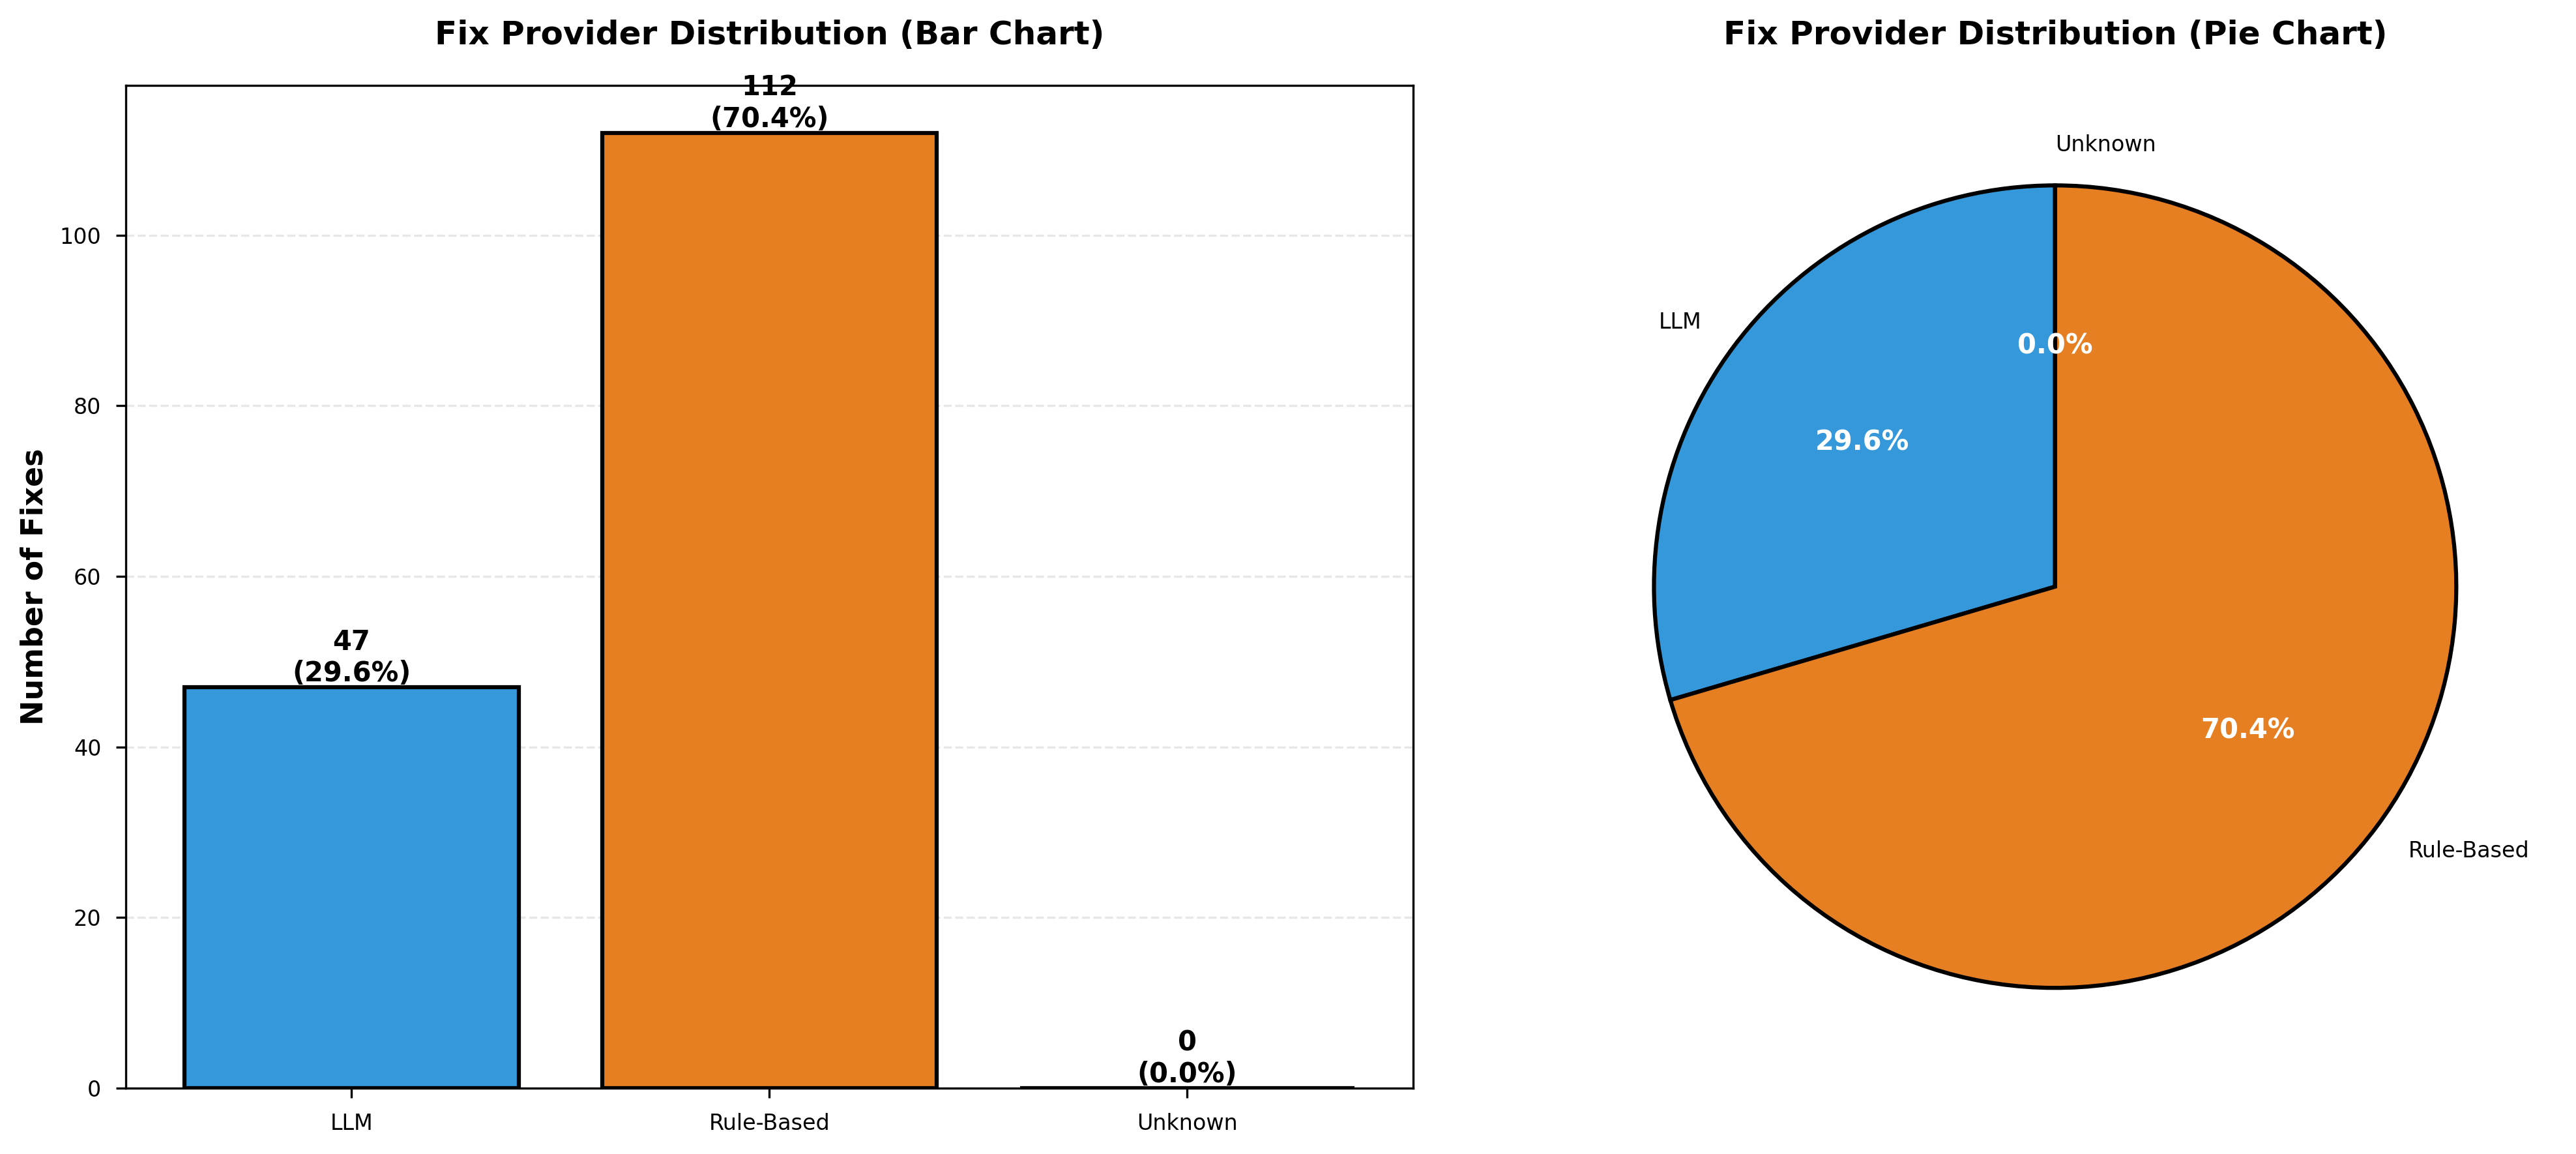

✓ Fix provider distribution plot saved


In [13]:
# Plot: Fix Provider Distribution (Bar Chart)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Bar chart
providers = ['LLM', 'Rule-Based', 'Unknown']
counts = [total_llm, total_rule_based, total_unknown]
colors = ['#3498db', '#e67e22', '#95a5a6']

bars = ax1.bar(providers, counts, color=colors, edgecolor='black', linewidth=1.5)

for bar, val in zip(bars, counts):
    height = bar.get_height()
    percentage = (val / sum(counts) * 100) if sum(counts) > 0 else 0
    ax1.text(bar.get_x() + bar.get_width()/2., height,
            f'{int(val)}\n({percentage:.1f}%)',
            ha='center', va='bottom', fontsize=10, fontweight='bold')

ax1.set_ylabel('Number of Fixes', fontsize=11, fontweight='bold')
ax1.set_title('Fix Provider Distribution (Bar Chart)', fontsize=12, fontweight='bold', pad=15)
ax1.grid(axis='y', alpha=0.3, linestyle='--')
ax1.set_axisbelow(True)

# Pie chart
if sum(counts) > 0:
    wedges, texts, autotexts = ax2.pie(counts, labels=providers, colors=colors,
                                         autopct='%1.1f%%', startangle=90,
                                         wedgeprops={'edgecolor': 'black', 'linewidth': 1.5})
    
    for autotext in autotexts:
        autotext.set_color('white')
        autotext.set_fontweight('bold')
        autotext.set_fontsize(10)
    
    ax2.set_title('Fix Provider Distribution (Pie Chart)', fontsize=12, fontweight='bold', pad=15)
else:
    ax2.text(0.5, 0.5, 'No fixes found', ha='center', va='center', fontsize=12)
    ax2.set_xlim(-1, 1)
    ax2.set_ylim(-1, 1)

plt.tight_layout()
plt.savefig('data/fix_provider_distribution.png', bbox_inches='tight')
plt.show()

print("✓ Fix provider distribution plot saved")

## 4. Iteration Impact Analysis

In [14]:
# Filter workflows with iterations
iterative_workflows = mitigation_df[mitigation_df['iterations_count'] > 0].copy()

print(f"\nWorkflows with iterations: {len(iterative_workflows)}/{len(mitigation_df)}")

if len(iterative_workflows) > 0:
    # Compute vulnerability reduction
    iterative_workflows['vulnerability_reduction'] = \
        iterative_workflows['initial_detections'] - iterative_workflows['iteration_detections']
    
    iterative_workflows['reduction_percentage'] = \
        (iterative_workflows['vulnerability_reduction'] / 
         iterative_workflows['initial_detections'] * 100).fillna(0)
    
    # Display sample
    display_cols = ['workflow_id', 'file', 'prompt_type', 'iterations_count',
                    'initial_detections', 'iteration_detections', 
                    'vulnerability_reduction', 'reduction_percentage']
    
    print("\nIteration Impact Sample:")
    display(iterative_workflows[display_cols].head(10))
    
    # Overall statistics
    print("\n" + "="*70)
    print("ITERATION IMPACT STATISTICS")
    print("="*70)
    print(f"Average vulnerability reduction: {iterative_workflows['vulnerability_reduction'].mean():.2f}")
    print(f"Median vulnerability reduction: {iterative_workflows['vulnerability_reduction'].median():.2f}")
    print(f"Average reduction percentage: {iterative_workflows['reduction_percentage'].mean():.2f}%")
    print("="*70)
else:
    print("\nNo workflows with iterations found.")
    iterative_workflows['vulnerability_reduction'] = []
    iterative_workflows['reduction_percentage'] = []


Workflows with iterations: 22/84

Iteration Impact Sample:


,workflow_id,file,prompt_type,iterations_count,initial_detections,iteration_detections,vulnerability_reduction,reduction_percentage
2,20251219_154533,CWE-022/author_1.py,SecurityEval,2,1,2,-1,-100.0
5,20251219_164453,CWE-080/author_1.py,SecurityEval,2,2,4,-2,-100.0
15,20251219_170144,CWE-259/author_2.py,SecurityEval,1,1,1,0,0.0
18,20251219_170511,CWE-319/author_1.py,SecurityEval,6,1,7,-6,-600.0
19,20251219_170947,CWE-319/author_2.py,SecurityEval,6,2,12,-10,-500.0
22,20251220_184438,CWE-326/author_1.py,SecurityEval,2,2,4,-2,-100.0
23,20251220_184717,CWE-326/author_2.py,SecurityEval,1,1,1,0,0.0
25,20251220_185337,CWE-331/author_1.py,SecurityEval,6,1,6,-5,-500.0
29,20251220_190117,CWE-454/author_1.py,SecurityEval,6,1,6,-5,-500.0
31,20251220_190428,CWE-522/author_1.py,SecurityEval,1,1,1,0,0.0



ITERATION IMPACT STATISTICS
Average vulnerability reduction: -4.73
Median vulnerability reduction: -4.50
Average reduction percentage: -283.33%


In [15]:
# Export iteration impact table
if len(iterative_workflows) > 0:
    output_path = Path('data/iteration_impact.csv')
    export_cols = ['workflow_id', 'file', 'prompt_type', 'iterations_count',
                   'initial_detections', 'iteration_detections',
                   'vulnerability_reduction', 'reduction_percentage',
                   'total_fixed', 'total_remaining']
    iterative_workflows[export_cols].to_csv(output_path, index=False)
    print(f"✓ Iteration impact table exported to: {output_path}")

✓ Iteration impact table exported to: data\iteration_impact.csv



Average Reduction by Prompt Type:


,Prompt_Type,Avg_Reduction,Avg_Reduction_Pct,Count
0,Manual,-6.666667,-281.481481,9
1,SecurityEval,-3.384615,-284.615385,13


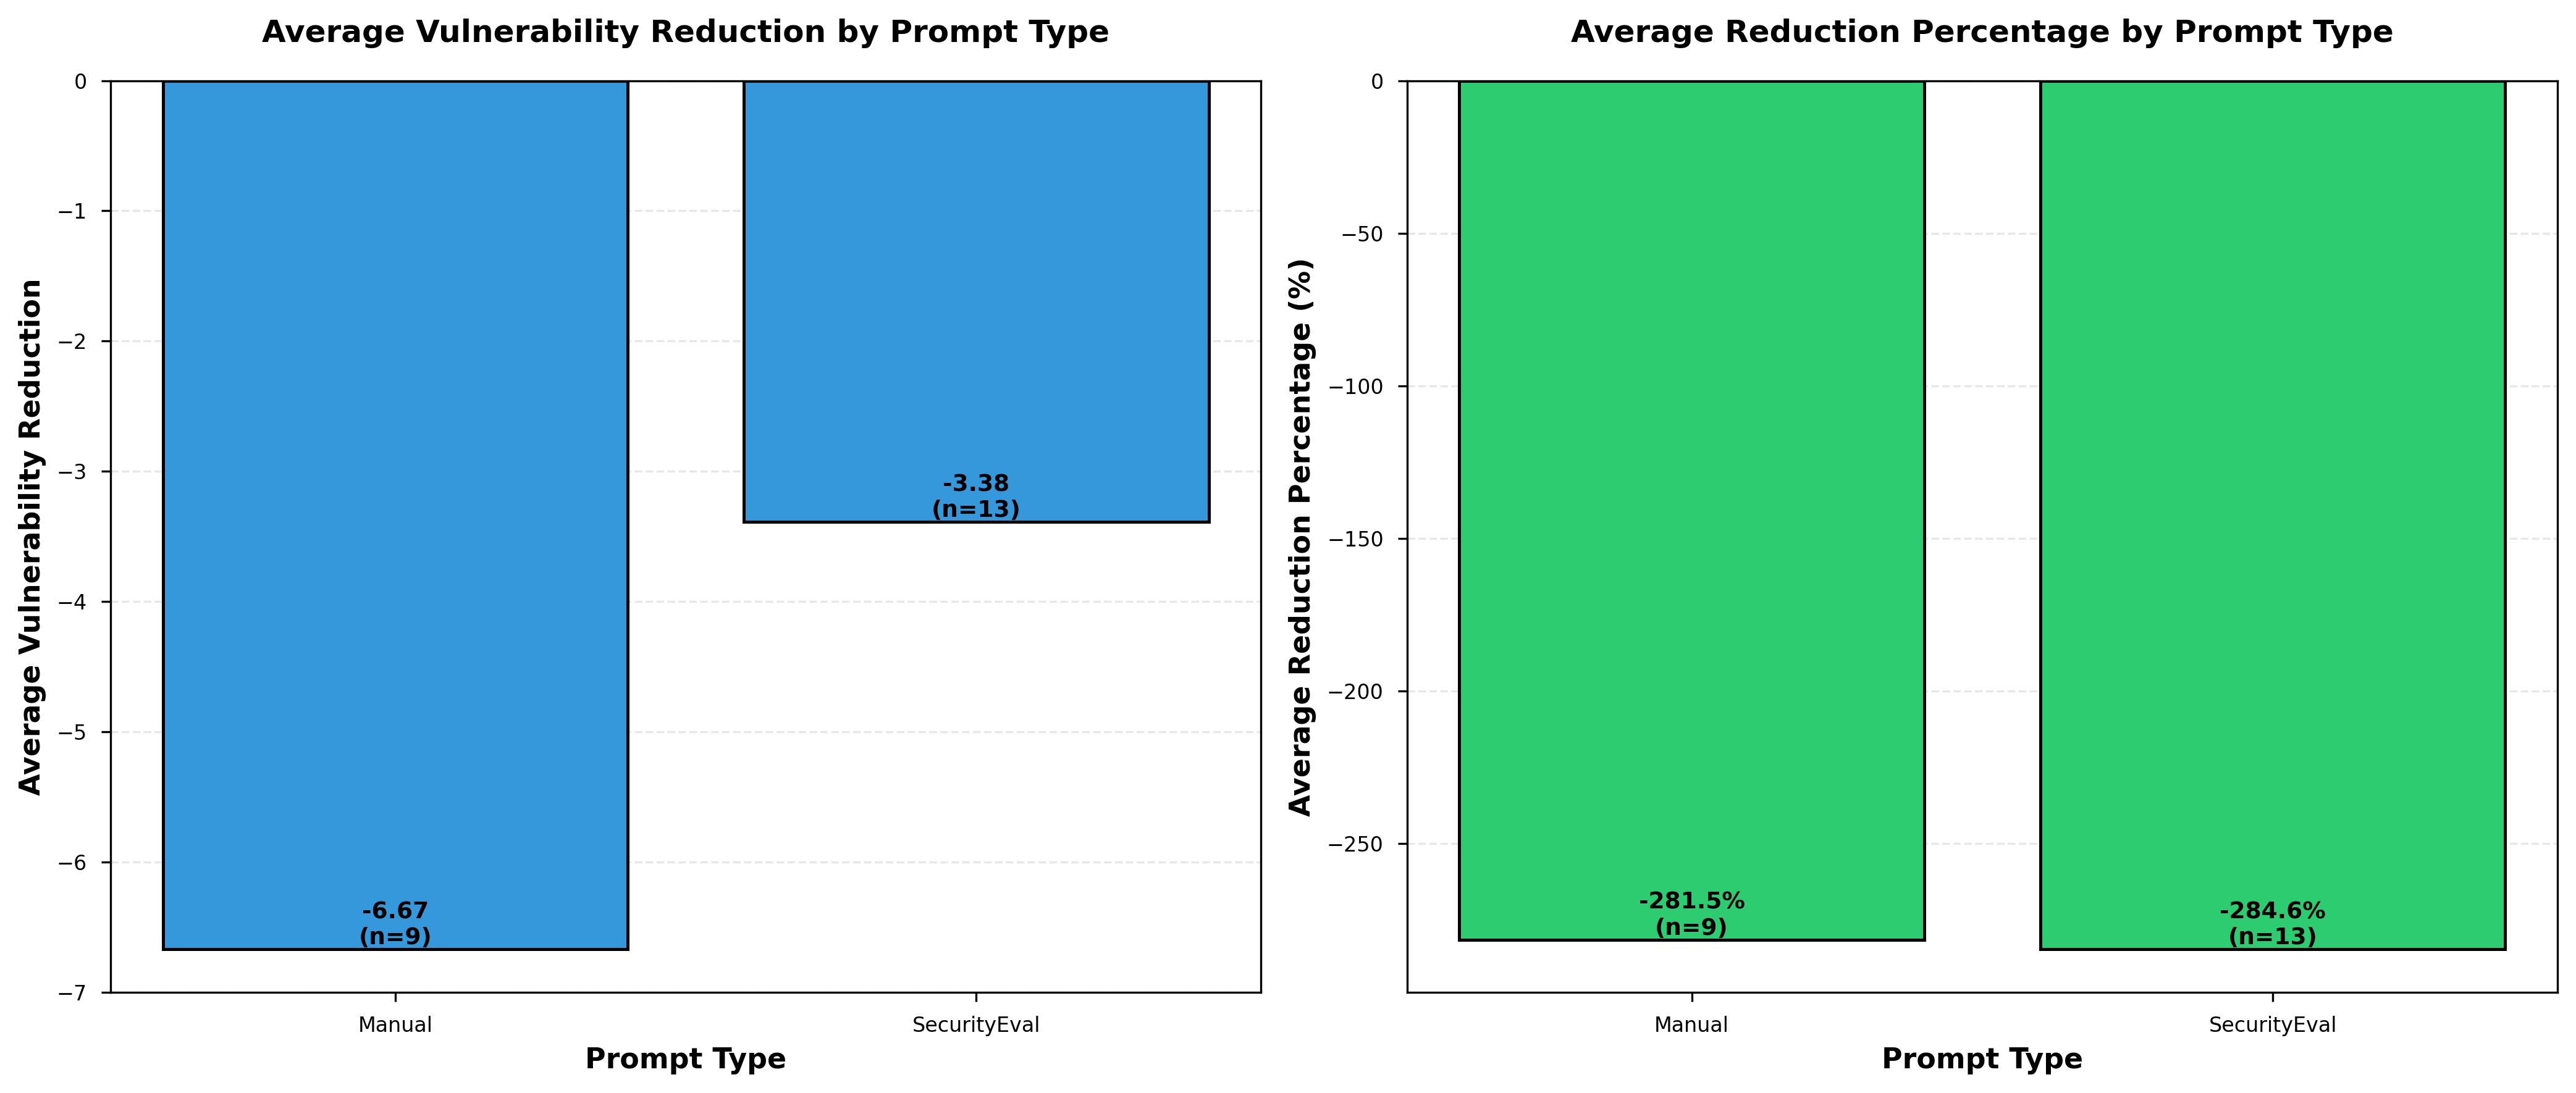

✓ Iteration reduction plots saved


In [16]:
# Plot: Average Reduction per Prompt Type
if len(iterative_workflows) > 0:
    # Group by prompt type
    reduction_by_type = iterative_workflows.groupby('prompt_type').agg({
        'vulnerability_reduction': 'mean',
        'reduction_percentage': 'mean',
        'workflow_id': 'count'
    }).reset_index()
    
    reduction_by_type.columns = ['Prompt_Type', 'Avg_Reduction', 'Avg_Reduction_Pct', 'Count']
    
    print("\nAverage Reduction by Prompt Type:")
    display(reduction_by_type)
    
    # Create plot
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))
    
    # Plot 1: Average absolute reduction
    bars1 = ax1.bar(reduction_by_type['Prompt_Type'], 
                    reduction_by_type['Avg_Reduction'],
                    color='#3498db', edgecolor='black', linewidth=1.2)
    
    for bar, val, count in zip(bars1, reduction_by_type['Avg_Reduction'], reduction_by_type['Count']):
        height = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width()/2., height,
                f'{val:.2f}\n(n={int(count)})',
                ha='center', va='bottom', fontsize=9, fontweight='bold')
    
    ax1.set_xlabel('Prompt Type', fontsize=11, fontweight='bold')
    ax1.set_ylabel('Average Vulnerability Reduction', fontsize=11, fontweight='bold')
    ax1.set_title('Average Vulnerability Reduction by Prompt Type', 
                  fontsize=12, fontweight='bold', pad=15)
    ax1.grid(axis='y', alpha=0.3, linestyle='--')
    ax1.set_axisbelow(True)
    
    # Plot 2: Average percentage reduction
    bars2 = ax2.bar(reduction_by_type['Prompt_Type'], 
                    reduction_by_type['Avg_Reduction_Pct'],
                    color='#2ecc71', edgecolor='black', linewidth=1.2)
    
    for bar, val, count in zip(bars2, reduction_by_type['Avg_Reduction_Pct'], reduction_by_type['Count']):
        height = bar.get_height()
        ax2.text(bar.get_x() + bar.get_width()/2., height,
                f'{val:.1f}%\n(n={int(count)})',
                ha='center', va='bottom', fontsize=9, fontweight='bold')
    
    ax2.set_xlabel('Prompt Type', fontsize=11, fontweight='bold')
    ax2.set_ylabel('Average Reduction Percentage (%)', fontsize=11, fontweight='bold')
    ax2.set_title('Average Reduction Percentage by Prompt Type', 
                  fontsize=12, fontweight='bold', pad=15)
    ax2.grid(axis='y', alpha=0.3, linestyle='--')
    ax2.set_axisbelow(True)
    
    plt.tight_layout()
    plt.savefig('data/iteration_reduction_by_prompt_type.png', bbox_inches='tight')
    plt.show()
    
    print("✓ Iteration reduction plots saved")
else:
    print("\nSkipping iteration impact plots (no iterative workflows)")

## Summary

In [17]:
print("\n" + "="*70)
print("MITIGATION EVALUATION - COMPLETE")
print("="*70)

print("\nKey Findings:")
print(f"  • Total workflows analyzed: {len(mitigation_df)}")
print(f"  • Overall fix success rate: {(mitigation_df['total_fixed'].sum() / mitigation_df['total_identified'].sum() * 100):.2f}%")
print(f"  • Total vulnerabilities fixed: {mitigation_df['total_fixed'].sum()}")
print(f"  • Total vulnerabilities remaining: {mitigation_df['total_remaining'].sum()}")

if total_fixes > 0:
    print(f"\n  Fix Provider Breakdown:")
    print(f"    - LLM fixes: {total_llm} ({total_llm/total_fixes*100:.1f}%)")
    print(f"    - Rule-based fixes: {total_rule_based} ({total_rule_based/total_fixes*100:.1f}%)")
    print(f"    - Unknown: {total_unknown} ({total_unknown/total_fixes*100:.1f}%)")

if len(iterative_workflows) > 0:
    print(f"\n  Iteration Impact:")
    print(f"    - Workflows with iterations: {len(iterative_workflows)}")
    print(f"    - Average vulnerability reduction: {iterative_workflows['vulnerability_reduction'].mean():.2f}")
    print(f"    - Average reduction percentage: {iterative_workflows['reduction_percentage'].mean():.2f}%")

print("\nOutputs Generated:")
print("  • mitigation_summary.csv")
print("  • fix_provider_summary.csv")
print("  • mitigation_fixed_vs_remaining.png")
print("  • mitigation_success_rate_distribution.png")
print("  • mitigation_top_fixed_cwes.png")
print("  • mitigation_top_remaining_cwes.png")
print("  • fix_provider_distribution.png")
if len(iterative_workflows) > 0:
    print("  • iteration_impact.csv")
    print("  • iteration_reduction_by_prompt_type.png")
print("="*70)


MITIGATION EVALUATION - COMPLETE

Key Findings:
  • Total workflows analyzed: 84
  • Overall fix success rate: 93.95%
  • Total vulnerabilities fixed: 202
  • Total vulnerabilities remaining: 13

  Fix Provider Breakdown:
    - LLM fixes: 47 (29.6%)
    - Rule-based fixes: 112 (70.4%)
    - Unknown: 0 (0.0%)

  Iteration Impact:
    - Workflows with iterations: 22
    - Average vulnerability reduction: -4.73
    - Average reduction percentage: -283.33%

Outputs Generated:
  • mitigation_summary.csv
  • fix_provider_summary.csv
  • mitigation_fixed_vs_remaining.png
  • mitigation_success_rate_distribution.png
  • mitigation_top_fixed_cwes.png
  • mitigation_top_remaining_cwes.png
  • fix_provider_distribution.png
  • iteration_impact.csv
  • iteration_reduction_by_prompt_type.png
